In [1]:
from time import time
import pandas as pd
import psycopg2
import numpy as np
import gc
import operator

from sklearn.model_selection import train_test_split
from sklearn.decomposition import NMF

from scipy.stats.stats import pearsonr

In [2]:
import sys 
import os
sys.path.append(os.path.abspath("/home/scidb/HeartRatePatterns/Python"))
from LogisticRegresion import ajustLogisticRegression
from PlotWords import plotWord

In [3]:
def selectMatrix(dbname="mimic") :
    conn = psycopg2.connect("dbname="+dbname)
    cur = conn.cursor()
    select_stament = ("SELECT m.subject_id,m.word,m.counting,s.isalive "
                      " FROM matrix m LEFT JOIN subjectwords s ON m.subject_id=s.subject_id"
    )
#                      " WHERE m.word in (select word from wordspearson where p1>0.01 order by p1 desc limit 400) "
    cur.execute(select_stament)
    select = []
    for row in cur :
        select.append((row))
    cur.close()
    conn.close()
    return select

In [4]:
def convertMatrix() :
    labels = ['subject_id', 'Word', 'Counting','isAlive']
    df = pd.DataFrame.from_records(selectMatrix(), columns=labels)
    print(len(df))
    table = pd.pivot_table(df,index=["subject_id","isAlive"],columns=["Word"],values=["Counting"],
                       aggfunc={"Counting":[np.sum]},fill_value=0)
    table.columns = [value[2] for value in table.columns.values]
    return table

In [5]:
def generateNMF(patients_train,survived_train,patients_test,survived_test,n_components=30) :
    nmf = NMF(n_components=n_components, random_state=1,alpha=.1, l1_ratio=.5)
    patients_trainnmf = nmf.fit_transform(patients_train)
    H = nmf.components_
    patients_testnmf = nmf.transform(patients_test)
    modelnmf = ajustLogisticRegression(patients_trainnmf,survived_train,patients_testnmf,survived_test)
    return nmf,modelnmf,patients_testnmf

In [6]:
def findpatient(message,table,beats):
    located = table
    groupsize = located.shape[0]
    deads = sum(located.index.labels[1].tolist())
    percent = -1 if groupsize==0 else deads/groupsize
    if groupsize!=0:
        print(message,"groupsize:%d"%groupsize,"deads:%d"%deads,"percent:{0:.2%}".format(percent),beats)


In [7]:
t0=time()
table = convertMatrix()
print("converMatrix done in %0.3fs." % (time() - t0))
print(table.shape)
gc.collect()

134706
converMatrix done in 4.549s.
(658, 5610)


14

In [8]:
table.sort_index(inplace=True,level='isAlive')
survived = table.index.labels[1].tolist()
patients = table.values

In [9]:
patients_train, patients_test,survived_train, survived_test = train_test_split(patients,survived,test_size=0.2, random_state=42)

In [10]:
n_components=42
nmf,modelnmf,pat_testnmf = generateNMF(patients,survived,patients_test,survived_test,n_components=n_components)

acurracy is 74.24%


In [11]:
components = nmf.components_

In [12]:
components.shape

(42, 5610)

In [13]:
compoT = np.transpose(components)
compoT.shape

(5610, 42)

In [14]:
def sortBeats(compoT,table):
    predicts = modelnmf.predict_proba(compoT)[:,1]
    beats = list(table)
    n99,n90,n80,n70,alive = 0,0,0,0,0
    sortedBeats = {}
    for i in range(0,len(predicts)):
        sortedBeats[beats[i]]=predicts[i]
        if predicts[i]>.99 :
            n99+=1
        else:
            if predicts[i]>.90 :
                n90+=1
            else:
                if predicts[i]>.80 :
                    n80+=1
                else:
                    if predicts[i]>.70 :
                        n70+=1
                    else:
                        alive+=1
    print("over99:%d" %n99,"{0:.2%}".format(n99/5621),"over90:%d" %n90,"{0:.2%}".format(n90/5621),"over80%d:"%n80,
          "{0:.2%}".format(n80/5621),"over70:%d"%n70,"{0:.2%}".format(n70/5621),"under:%d"%alive,
          "{0:.2%}".format(alive/5621))
    return sorted(sortedBeats.items(), key=operator.itemgetter(1),reverse=True)
sortedBeats = sortBeats(compoT,table)
beatKeys = []
for key,value in sortedBeats:
    beatKeys.append(key)
    print(key,value)
#print(sortedBeats[:20])

over99:127 2.26% over90:321 5.71% over801783: 31.72% over70:2863 50.93% under:516 9.18%
daddd 0.999999999125
ddadd 0.999999998399
dddad 0.999999997645
iiiii 0.999999960586
adadd 0.99999972349
dadda 0.999999052559
adbad 0.999995841963
aaaff 0.999991035891
ffaaa 0.999990829554
addad 0.99998806899
aaffa 0.999985882779
affaa 0.999985260856
afafa 0.999970721036
afaaf 0.999965216607
faaaf 0.999962913926
ccecc 0.999958848025
dbadb 0.999951229836
baccc 0.999951066949
faafa 0.99995081032
aafaf 0.999950136941
fafaa 0.999945559824
cccba 0.999936183507
cccec 0.999935896241
ddbdd 0.999934034563
ddada 0.999931749025
dddbd 0.999922379923
cbaba 0.999895185235
dbddd 0.999807220554
cccce 0.999798890218
adddd 0.999785322925
abacc 0.999762405024
ddaad 0.999759911609
eccec 0.999758856183
ceccc 0.999711963868
accba 0.999683249783
cecce 0.999683106799
ccece 0.999673856482
addda 0.999641007334
ceeee 0.99954642962
ccbac 0.99951168402
daadd 0.9995044862
addba 0.999376386364
cecec 0.999325778149
eeeec 0.99931267

faafg 0.903062701711
bdafa 0.902786573929
ffaag 0.902655846865
aagdd 0.902396419148
affda 0.902312118598
dbdbb 0.902176740238
bgbaa 0.902071972477
agaba 0.902015523092
abgba 0.901672430517
babbg 0.900875443191
ababc 0.900314661082
fdafa 0.900174562635
afdab 0.900049419256
aadgd 0.899841017714
gbaba 0.899815743933
ddgda 0.899684400562
addbb 0.899442464553
fgaaf 0.899347294306
cbaab 0.89882892609
ddgad 0.898515896132
fadda 0.898036308738
adgdd 0.897873065811
abfbd 0.897846760544
gafaf 0.897450486338
aafah 0.897334657574
aaahd 0.897289649168
dadag 0.897099742724
gagaf 0.896895398582
aagad 0.896665366078
ahfaa 0.896636512129
bdadd 0.896289737366
dafab 0.896245189771
abdaf 0.896166247661
adhda 0.895835641449
bfabd 0.895769705946
fffaf 0.895670179468
hdaaa 0.89543865131
dffaa 0.895411179342
fadaf 0.895216253903
adabd 0.894293807254
abadd 0.894209921667
ajaaa 0.893711874974
dddga 0.893639955201
ddadg 0.892981690477
dadga 0.892839985548
aabbg 0.892812336665
bfada 0.892573845994
ddfff 0.8923172

hdbad 0.820925629969
fggaf 0.820909652202
dfgga 0.82088316337
bcfbb 0.820753211887
gdgag 0.820648714304
ffddf 0.820638520882
aadhh 0.820614221104
aggdd 0.820611147211
hffaa 0.820575929649
dafgg 0.820491658947
ffgfa 0.820488876453
ffaba 0.820449398905
fadfd 0.820443319198
abbgd 0.820436196936
abddf 0.820424517763
abcbd 0.820423995262
fbfab 0.820420818842
dfdfa 0.820406473904
adbcb 0.820324717318
bcdaa 0.820218132004
iiill 0.820213489625
baacd 0.82017496068
bbaah 0.820167709994
dggad 0.820165907698
lilii 0.820165474649
illii 0.820165474649
ilili 0.820165474649
gafad 0.820163425324
cbeee 0.820002698221
dbagb 0.819991532599
gdaaf 0.819916912324
habbb 0.819838357426
gbadb 0.819827561073
bbcfb 0.819817998467
ddafg 0.819804338589
faddf 0.819746822033
dafah 0.819743556009
fahaf 0.819723989467
hbaab 0.819715728689
fdhad 0.81969230108
gaddb 0.819649925889
dfafg 0.819640979152
ahfda 0.819598755091
agadg 0.819548832625
bfdbd 0.819499517269
fajaa 0.819499501136
bbabg 0.819473657714
abaff 0.81944135

gbaac 0.795379040638
bgfba 0.795340253519
dadbg 0.795295657852
gbaga 0.795282944464
ahadb 0.795266707629
fbbgb 0.795262322813
gdggg 0.795257499616
ddaaj 0.795200759112
bafbg 0.79519241931
dagbd 0.7951744463
cgbbb 0.79512847672
bbbfg 0.795125097069
bhbbf 0.795109435673
dgbda 0.795102168577
faghg 0.795089968921
bfafd 0.795088366091
gffff 0.795082939545
bfadg 0.795071429556
ddbaf 0.795068547259
afgja 0.795063311475
hfagg 0.795060892413
fggga 0.795033112793
acbda 0.795031385711
bfbgb 0.795012312473
bfafb 0.794997936942
bgdbd 0.794996627592
dahgf 0.794968654694
agbag 0.794938891651
adcdb 0.794935849565
bdgda 0.794933395725
jafgg 0.794930179967
cbafa 0.794928557133
becee 0.794924167863
gcbab 0.794921889353
ggfgg 0.794910585082
agjaj 0.794901928982
jafga 0.794901821674
bddaf 0.79489493372
jdbbb 0.794879940301
dbacb 0.794854850697
babaj 0.794846545455
dajja 0.794827633504
hdabb 0.794824273509
hhfaa 0.794819086719
adhha 0.794815093338
badah 0.794810906842
fdfdb 0.794810650738
ggggg 0.7948084194

beicb 0.78322157462
ceceb 0.783216898923
gbbcc 0.783190740779
bceib 0.783189153987
cbaib 0.783188864665
icbbc 0.78318487545
abbjb 0.783177004176
bbcic 0.78316626652
cdbda 0.783156572013
fabdc 0.783152816282
ffdgf 0.783151961705
cfbca 0.783138182433
aadcf 0.783121504783
acbcd 0.783119451874
ccdac 0.783117103522
lbbbb 0.783116742904
ieebb 0.78310998783
abgbf 0.783106031012
cebib 0.783102337972
hbcba 0.783085864637
dbbdf 0.783085086607
bggdf 0.783079908588
fgbbb 0.783046876427
cagba 0.783046484426
eekbb 0.783028727828
fabcc 0.783026777535
jfaba 0.783005608922
gcbba 0.782988719984
facbc 0.782986203964
ibbab 0.782977745529
adfbc 0.782977085394
cdcdc 0.782968452815
cafca 0.782963937778
abbfg 0.782962185806
ibeeb 0.782955233577
ccadd 0.782940410139
cciib 0.782937080274
fcdca 0.782918184609
bcaic 0.782916428596
lbcbb 0.782909595294
bhagb 0.782890572102
cfaaf 0.782885837731
cfaac 0.782878590711
beafa 0.78286794915
bbfff 0.782860522656
aacib 0.782859378463
cagbb 0.782832816795
eaada 0.7828246458

bbabe 0.591334297354
eaccc 0.590718605441
ecbac 0.589834781768
aabcb 0.589278615468
aceae 0.589041688703
ebbae 0.588750444958
cbcab 0.588706825281
eacaa 0.587793057461
ecaba 0.586909107334
bcaae 0.586400085364
ebaee 0.585717204611
eaacb 0.584277947818
bbeab 0.583777245458
baeee 0.581778892039
ebbba 0.580089931408
ccaea 0.579753403653
aeaec 0.579004231038
eaeca 0.57851039462
baace 0.577673021848
eecae 0.577492830764
bdbdb 0.577298742734
eabac 0.577031478787
bbaeb 0.576404212442
beabb 0.5741619104
caaee 0.569982612824
bcbca 0.569123558194
eaabc 0.568979180847
aecbb 0.566623081441
aabce 0.564854243825
cccea 0.564425332751
cbaea 0.564274754848
ebabe 0.563241666731
acaec 0.561681230668
eccac 0.561042692564
bbbae 0.558967369192
aeecc 0.555700008711
abcab 0.554539621253
ebabb 0.552892874815
aebbb 0.552527109353
acabc 0.551266419888
aecac 0.550302901841
accce 0.549644876038
beaac 0.547318425157
eeeea 0.545670238773
aacee 0.542284150941
aecab 0.541224742152
cceaa 0.53957761721
caeca 0.533854449

In [15]:
table.sort_values(by=beatKeys)
survived = table.index.labels[1].tolist()
patients = table.values

In [16]:
nmf,modelnmf,pat_testnmf = generateNMF(patients,survived,patients_test,survived_test,n_components=n_components)

acurracy is 74.24%


In [17]:
components = nmf.components_

In [18]:
def print_top_words(model, feature_names, n_top_words,topics=[]):
    for topic_idx, topic in enumerate(components):
        if(topics==[] or topic_idx in topics):
            message = "Topic #%d: " % topic_idx
            features = [{"word":feature_names[i],"p1":str(topic[i])} for i in topic.argsort()[:-n_top_words - 1:-1] if topic[i] > 1]
#            plotWord(features[:5])
#            message += " ".join()
            print(message,features[:5])
#        print(topic.argsort())
    print()

In [19]:
n_top_words = 1000
print_top_words(components, list(table), n_top_words)

Topic #0:  [{'word': 'cacac', 'p1': '11.5081302212'}, {'word': 'acaac', 'p1': '11.1069883283'}, {'word': 'accac', 'p1': '10.741372641'}, {'word': 'acacc', 'p1': '10.5348864749'}, {'word': 'caaca', 'p1': '10.2338461779'}]
Topic #1:  [{'word': 'cccec', 'p1': '9.62438214188'}, {'word': 'ccecc', 'p1': '9.45772212718'}, {'word': 'cccce', 'p1': '9.0373220571'}, {'word': 'ecccc', 'p1': '8.92132385713'}, {'word': 'ceccc', 'p1': '8.85438248491'}]
Topic #2:  [{'word': 'adddd', 'p1': '18.4953953255'}, {'word': 'dddda', 'p1': '18.3846569704'}, {'word': 'addad', 'p1': '9.54461459841'}, {'word': 'dadda', 'p1': '9.50770409357'}, {'word': 'ddada', 'p1': '9.22835960046'}]
Topic #3:  [{'word': 'beeee', 'p1': '11.1578513072'}, {'word': 'eeeeb', 'p1': '10.8264906485'}, {'word': 'bbbbe', 'p1': '8.28700435423'}, {'word': 'ebbbb', 'p1': '7.98591941526'}, {'word': 'bbeee', 'p1': '6.10921450739'}]
Topic #4:  [{'word': 'bdddd', 'p1': '10.6219716596'}, {'word': 'ddddb', 'p1': '10.4645443083'}, {'word': 'ddbdd', 

In [20]:
components.shape

(42, 5610)

In [21]:
i,total=0,0
for component in components:
    i += 1
    total +=sum(component)
    print(sum(component),end=", ")
#    for comp in component:
#        i += 1
#        total +=comp
#        if comp>1:
#            print(comp)
print(i,total,total/i)


231.347605205, 194.103000659, 119.004141986, 111.863741417, 146.336943872, 55.9937763859, 206.444071868, 350.619930564, 214.807346815, 68.8104084588, 398.211395792, 175.678469344, 159.829435946, 158.590516247, 173.254242059, 58.6943275866, 213.816592938, 123.309023106, 179.411578217, 289.31683731, 347.550152872, 731.292760003, 74.1609957792, 162.874986588, 413.226383228, 279.26474194, 134.361170042, 143.477447519, 94.4607675547, 100.633052354, 153.317689052, 194.571284356, 155.813644888, 152.295840932, 128.438583026, 141.861060751, 149.174968531, 266.101400225, 193.479281496, 210.434533494, 73.0168748823, 130.971649543, 42 8060.22265483 191.91006321


In [22]:
patients_trainnmf = nmf.transform(patients_train)

In [23]:
from operator import itemgetter
pearsonList = []
for i in range(n_components):
    patientpear=patients_trainnmf[:,i]
    pearson = pearsonr(patientpear,survived_train)
    if(pearson[0]>0):
        pearsonList.append({'word':i,'p1':pearson[0],'p2':pearson[1]})
sortedList = sorted(pearsonList, key=itemgetter('p1'), reverse=True)
for i in range(10):
    print(sortedList[i])

{'word': 20, 'p2': 0.0048097966495162323, 'p1': 0.12276295131009708}
{'word': 12, 'p2': 0.042213894648221249, 'p1': 0.088609995660381399}
{'word': 25, 'p2': 0.14569015916687661, 'p1': 0.063524766118355447}
{'word': 19, 'p2': 0.20237438296398352, 'p1': 0.055673949904256642}
{'word': 37, 'p2': 0.24140728263060268, 'p1': 0.051167069515557752}
{'word': 40, 'p2': 0.28547345388682649, 'p1': 0.046657195150798407}
{'word': 35, 'p2': 0.36064340983988685, 'p1': 0.039937496843131352}
{'word': 2, 'p2': 0.38487371231774581, 'p1': 0.037964740707751965}
{'word': 8, 'p2': 0.53782990080391713, 'p1': 0.026922324983617709}
{'word': 18, 'p2': 0.53979968938260581, 'p1': 0.026792064796044769}


In [24]:
n_top_words = 10
topics = [20,]
columns = list(table)
print_top_words(components, columns, 100,topics)
#print_top_beats(components, list(table), n_top_words,table,topics)

Topic #20:  [{'word': 'abbfa', 'p1': '2.84590087348'}, {'word': 'aabbf', 'p1': '2.59645818571'}, {'word': 'bbfab', 'p1': '2.57001305678'}, {'word': 'babfa', 'p1': '2.47446362926'}, {'word': 'bfabb', 'p1': '2.31528629919'}]



abbfa 13884038 13886869 mimic2wdb/matched/s14524/s14524-3192-08-21-15-56
aabbf 52298360 52299161 mimic2wdb/matched/s15624/s15624-3440-10-08-18-01
bbfab 4458022 4458908 mimic2wdb/matched/s04113/s04113-2760-06-29-22-45
babfa 3662943 3663930 mimic2wdb/matched/s15964/s15964-3477-07-18-04-17
bfabb 17264523 17266742 mimic2wdb/matched/s09366/s09366-3078-03-30-21-08


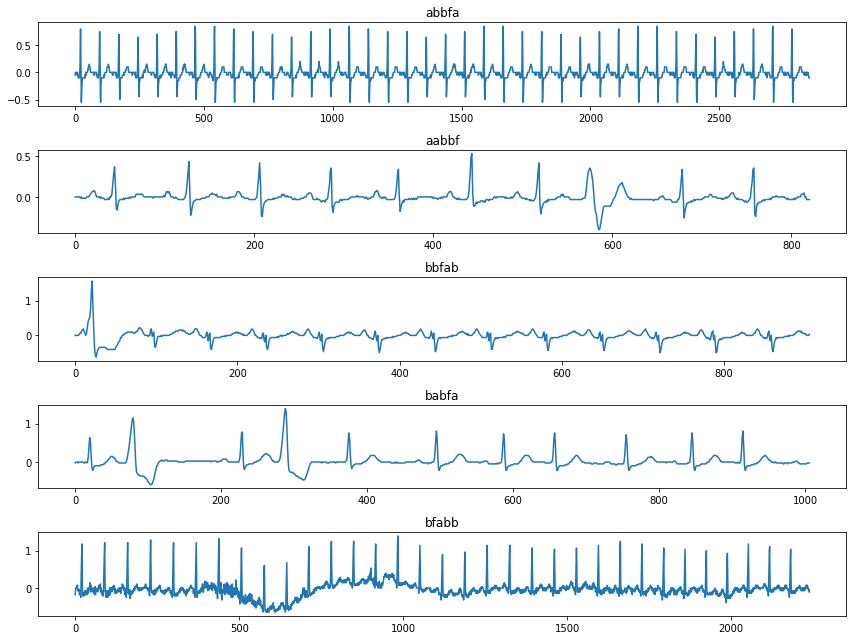

In [25]:
plotWord([{'word': 'abbfa', 'p1': '2.84590087348'}, 
          {'word': 'aabbf', 'p1': '2.59645818571'}, 
          {'word': 'bbfab', 'p1': '2.57001305678'}, 
          {'word': 'babfa', 'p1': '2.47446362926'}, 
          {'word': 'bfabb', 'p1': '2.31528629919'}])